In [1]:
#Let's import all the necessary libraries
import numpy as np
import torch
import torchvision
from torchvision import transforms as T
from PIL import Image
import requests
import cv2
from torch.utils.data import Dataset, random_split, DataLoader
from pycocotools.coco import COCO

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For high res images

In [2]:
#Model Initiation
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=None)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes=5)
#model.train()

In [3]:
# Load your custom-trained weights
model.load_state_dict(torch.load("trained_maskrcnn.pth"))

<All keys matched successfully>

In [4]:
model.eval()
model = model.cpu()

In [5]:
#coco datasets
model_classes = ['Robusta-Excelsa-Arabica-Liberica','Arabica','Excelsa','Liberica','Robusta']

#with open("cocoseg/train/_annotations.coco.json", "r") as file:
    #data = json.load(file)
   # print(data.get("categories", {}))
    #num = 0
    #while num < 5:
     #   model_classes.append(data.get("categories", {})[num].get("name",{}))
    #    num+=1
    #num = 0
len(model_classes) 

5

In [ ]:
def get_prediction(img_path, threshold=0.6):
  
  img = Image.open(img_path) # This is for local images
  transform = T.Compose([T.ToTensor()]) # Turn the image into a torch.tensor
  img = transform(img)
  img = img.cpu() # Only if GPU, otherwise comment this line
  pred = model([img]) # Send the image to the model. This runs on CPU, so its going to take time
  # Now we need to extract the bounding boxes and masks
  pred_score = list(pred[0]['scores'].detach().cpu().numpy())
  #pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
  #pred_t = max([i for i, x in enumerate(pred_score) if x > threshold])
  valid_indices = [i for i, x in enumerate(pred_score) if x > threshold]
  pred_t = max(valid_indices) if valid_indices else -1  # Use -1 or another fallback value

  masks = (pred[0]['masks'] > 0.5).squeeze().detach().cpu().numpy()
  pred_class = [model_classes[i] for i in list(pred[0]['labels'].cpu().numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class, pred_score

In [7]:
import random

In [73]:
def random_color_masks(mask):
    if mask is None or mask.shape[0] == 0 or mask.shape[1] == 0:
        print("Warning: Empty mask passed to random_color_masks().")
        return np.zeros((1, 1, 3), dtype=np.uint8)  # Return a valid small black mask

    colors = np.random.randint(0, 255, (1, 3), dtype=np.uint8)  # Generate random color
    colored_mask = np.zeros_like(mask, dtype=np.uint8)  # Create empty mask
    for i in range(3):  # Apply color to each channel
        colored_mask[:, :, i] = mask[:, :, 0] * colors[0, i]
    
    return colored_mask



In [ ]:
def instance_segmentation(img_path, threshold=0.6, rect_th=1, text_size=0.4, text_th=4):
    masks, boxes, pred_cls, pred_score = get_prediction(img_path, threshold=threshold)

    # Load image
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Error: Could not read image {img_path}. Check the file path.")
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    for i in range(len(masks)):
        mask = masks[i]

        # ✅ Debugging prints
        print(f"Mask {i} shape before processing: {mask.shape}")

        # Ensure mask is a NumPy array
        if not isinstance(mask, np.ndarray):
            print(f"Warning: Mask {i} is not a NumPy array. Skipping.")
            continue

        # Ensure mask has correct dimensions
        if len(mask.shape) == 2:  # Grayscale mask (H, W), needs (H, W, 3)
            mask = np.stack([mask] * 3, axis=-1)  # Convert to 3-channel

        # Ensure mask has valid size before resizing
        if mask.shape[0] == 0 or mask.shape[1] == 0:
            print(f"Warning: Mask {i} is empty. Skipping.")
            continue

        # Apply random color mask
        rgb_mask = random_color_masks(mask)
        if rgb_mask is None:
            print(f"Warning: rgb_mask {i} is None. Skipping.")
            continue

        # Resize mask to match image size
        rgb_mask = cv2.resize(rgb_mask, (img.shape[1], img.shape[0]))  # Width x Height
        print(f"RGB Mask {i} shape after resize: {rgb_mask.shape}")

        # Overlay mask on image
        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        confidence =f"{pred_cls[i]}: {pred_score[i]:.2f}"
        
        if pred_cls[i] == "Arabica":
            BG_COLOR = (255, 220, 120)  # Light yellow background for text
        if pred_cls[i] == "Robusta":
            BG_COLOR = (255, 220, 120)  # Light yellow background for text
        if pred_cls[i] == "Excelsa":
            BG_COLOR = (255, 220, 120)  # Light yellow background for text
        if pred_cls[i] == "Liberica":
            BG_COLOR = (255, 220, 120)  # Light yellow background for text

        # Define colors
        BOX_COLOR = (255, 200, 0)  # Yellow box
        TEXT_COLOR = (0, 0, 0)  # Black text
        BG_COLOR = (255, 220, 120)  # Light yellow background for text

        # Draw bounding box
        pt1 = tuple(int(x) for x in boxes[i][0])
        pt2 = tuple(int(x) for x in boxes[i][1])
        cv2.rectangle(img, pt1, pt2, color=(255, 0, 0), thickness=rect_th)
        print(pt1)
        print(pt2)
        # Draw background rectangle for text
        cv2.rectangle(img, pt1,(pt2[0],pt1[1]-10), BG_COLOR, -1)

        print(model_classes)
        cv2.putText(img, confidence, pt1, cv2.FONT_ITALIC, text_size, (0, 0, 0), thickness=text_th)

    print(f"Final image shape: {img.shape}")
    return img, pred_cls, masks, pred_score

Mask 0 shape before processing: (640, 640)
RGB Mask 0 shape after resize: (640, 640, 3)
(128, 259)
(260, 402)
['Robusta-Excelsa-Arabica-Liberica', 'Arabica', 'Excelsa', 'Liberica', 'Robusta']
Mask 1 shape before processing: (640, 640)
RGB Mask 1 shape after resize: (640, 640, 3)
(265, 0)
(440, 186)
['Robusta-Excelsa-Arabica-Liberica', 'Arabica', 'Excelsa', 'Liberica', 'Robusta']
Mask 2 shape before processing: (640, 640)
RGB Mask 2 shape after resize: (640, 640, 3)
(334, 123)
(521, 261)
['Robusta-Excelsa-Arabica-Liberica', 'Arabica', 'Excelsa', 'Liberica', 'Robusta']
Mask 3 shape before processing: (640, 640)
RGB Mask 3 shape after resize: (640, 640, 3)
(127, 102)
(239, 265)
['Robusta-Excelsa-Arabica-Liberica', 'Arabica', 'Excelsa', 'Liberica', 'Robusta']
Mask 4 shape before processing: (640, 640)
RGB Mask 4 shape after resize: (640, 640, 3)
(211, 402)
(327, 582)
['Robusta-Excelsa-Arabica-Liberica', 'Arabica', 'Excelsa', 'Liberica', 'Robusta']
Mask 5 shape before processing: (640, 640)

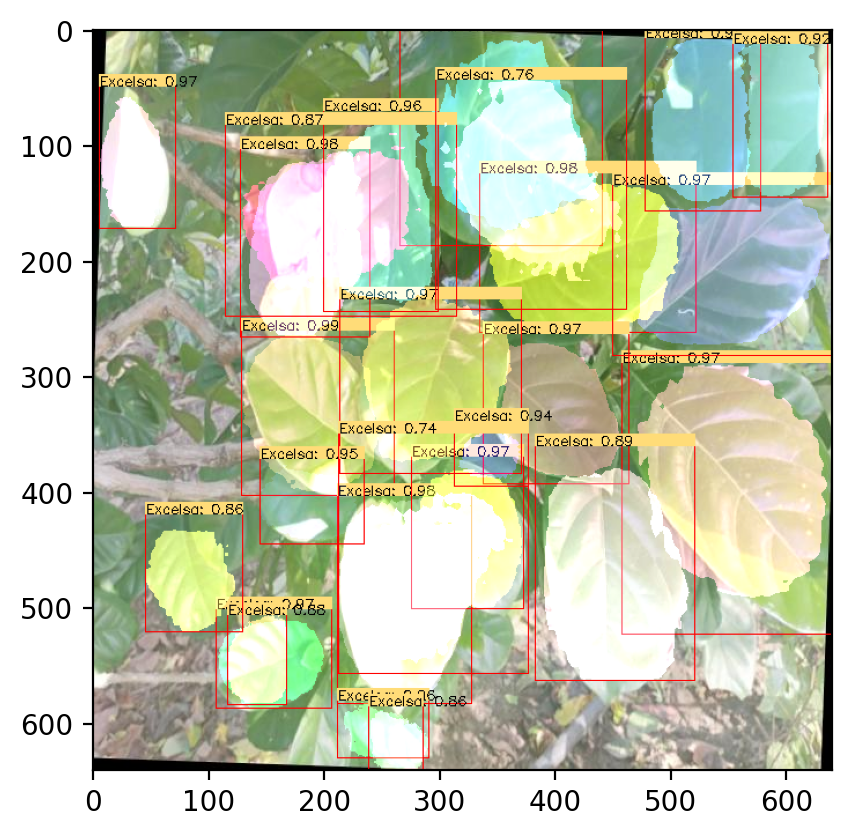

True

In [103]:
#img, pred_classes, masks = instance_segmentation('ww.jpg', rect_th=1, text_th=1)
img, pred_classes, masks, pred_score = instance_segmentation('rand.jpg',  text_th=1)
plt.imshow(img)
plt.show()
cv2.imwrite("saved_img.jpg",img)

In [ ]:
img, pred_classes, masks = instance_segmentation('Mdemo.jpg', rect_th=5, text_th=4)
plt.imshow(img)

In [ ]:
img, pred_classes, masks = instance_segmentation('test.jpg', rect_th=5, text_th=4)
plt.imshow(img)

In [ ]:
img, pred_classes, masks = instance_segmentation('demo.jpg', rect_th=5, text_th=4)
plt.imshow(img)